This notebook is to compare padam optimisors performance on ResNet 18 architecture with different p value

# Install requested packages

In [1]:
!pip install keras-rectified-adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8272 sha256=880617e28e82e6a958723e30d564022e60e16de79ec6d4b59aedf2665a3e25f2
  Stored in directory: /root/.cache/pip/wheels/28/1c/f2/1554bc7e22650af3ed067be67cca780212fac6955a272ca815
Successfully built keras-rectified-adam


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 26.1 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/qubvel/classification_models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-hdxdrw8_
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-hdxdrw8_
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.5 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20048 sha256=1a59432bdf11f8906aa35bbb30aea4bc9f8dc97d46551466a6ac49c0a435cc37
  Stored in directory: /tmp/pip-ephem-wheel-cache-4r9c54xp/wheels/e7/c3/c8/78c1f9edf72d00198ac018396707125272de9c1abdd99a4043
Successfully built image-classifiers


# Initialisation and data cleaning

In [13]:
# Import resnet lib
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import time
import tensorflow_addons as tfa
from classification_models.keras import Classifiers
from keras import backend as K

In [5]:
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Sun Apr 23 03:47:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

170498071/170498071 [==============================] - 13s 0us/step


# Build Resnet and padam

In [ ]:
# For resnet 50
"""
base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
"""
# model.summary()

"\nbase_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\npredictions = Dense(10, activation='softmax')(x)\n\nmodel = Model(inputs=base_model.input, outputs=predictions)\n"

In [7]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    shortcut = x
    if conv_shortcut:
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = BatchNormalization(name=name + '_0_bn')(shortcut)

    x = Conv2D(filters, kernel_size, strides=stride, padding='same', name=name + '_1_conv')(x)
    x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)

    x = Conv2D(4 * filters, kernel_size, padding='same', name=name + '_2_conv')(x)  # Change this line
    x = BatchNormalization(name=name + '_2_bn')(x)

    x = Add(name=name + '_add')([shortcut, x])
    x = Activation('relu', name=name + '_out')(x)
    return x


def create_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same', name='conv1')(inputs)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu', name='relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='pool1')(x)

    # ResNet-18: [2, 2, 2, 2] blocks for each stage
    x = resnet_block(x, 64, name='block1_0', conv_shortcut=True)
    x = resnet_block(x, 64, name='block1_1', conv_shortcut=False)

    x = resnet_block(x, 128, stride=2, name='block2_0', conv_shortcut=True)
    x = resnet_block(x, 128, name='block2_1', conv_shortcut=False)

    x = resnet_block(x, 256, stride=2, name='block3_0', conv_shortcut=True)
    x = resnet_block(x, 256, name='block3_1', conv_shortcut=False)

    x = resnet_block(x, 512, stride=2, name='block4_0', conv_shortcut=True)
    x = resnet_block(x, 512, name='block4_1', conv_shortcut=False)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
class Padam(tfa.optimizers.RectifiedAdam):
    def __init__(self, p=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p
        
    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_dtype = var.dtype.base_dtype
        local_step = tf.cast(self.iterations + 1, var_dtype)
        beta_1_t = tf.cast(self._get_hyper('beta_1', var_dtype), var_dtype)
        beta_2_t = tf.cast(self._get_hyper('beta_2', var_dtype), var_dtype)
        one_minus_beta_1_t = 1 - beta_1_t
        one_minus_beta_2_t = 1 - beta_2_t
        
        step_size = self._get_hyper('learning_rate', var_dtype) * (tf.sqrt(1 - tf.pow(beta_2_t, local_step)) / (1 - tf.pow(beta_1_t, local_step)))

        m = self.get_slot(var, 'm')
        m_t = (m * beta_1_t) + (grad * one_minus_beta_1_t)
        m_hat_t = m_t / (1 - tf.pow(beta_1_t, local_step))
        
        v = self.get_slot(var, 'v')
        v_t = (v * beta_2_t) + (tf.square(grad) * one_minus_beta_2_t)
        v_hat_t = v_t / (1 - tf.pow(beta_2_t, local_step))
        
        denom = tf.pow(tf.sqrt(v_hat_t) + K.epsilon(), self.p)
        var_t = var - step_size * (m_hat_t / denom)
        
        return tf.compat.v1.assign(var, var_t)

In [9]:
# Create ResNet-18 model
"""
# Old version
input_shape = (32, 32, 3)
num_classes = 10
model = create_resnet18(input_shape, num_classes)
"""
ResNet18, preprocess_input = Classifiers.get('resnet18')
input_shape = (32, 32, 3)  # For CIFAR-10
num_classes = 10  # For CIFAR-10

# include_top=false delete top layer in order to enable tunning
base_model = ResNet18(input_shape=input_shape, weights='imagenet', include_top=False)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

44920640/44920640 [==============================] - 3s 0us/step


In [10]:
def train_model_with_optimizer(optimizer, batch_size, epochs):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    input_shape = (32, 32, 3)  # For CIFAR-10
    num_classes = 10  # For CIFAR-10

    # include_top=false delete top layer in order to enable tunning
    base_model = ResNet18(input_shape=input_shape, weights='imagenet', include_top=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
    start_time = time.time()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    return history, training_time, model

In [14]:
# 100 epochs (Same as the paper)
p_values = [0.25, 0.125, 0.0625]
optimizers = {}

for p in p_values:
    optimizers[f'Padam_p_{p}'] = Padam(learning_rate=0.001, total_steps=10000, warmup_proportion=0.1, min_lr=0.0001, p=p)


histories_100epochs = {}
training_times_100epochs = {}
models = {}

for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer...")
    histories_100epochs[name], training_times_100epochs[name], models[name] = train_model_with_optimizer(optimizer, 128, 200)

for name, model in models.items():
    model.save(f'./Model/padam_100epochs_{name}.h5')

Training with Padam_p_0.25 optimizer...
Training with Padam_p_0.125 optimizer...
Training with Padam_p_0.0625 optimizer...


# Plot figure and save to local

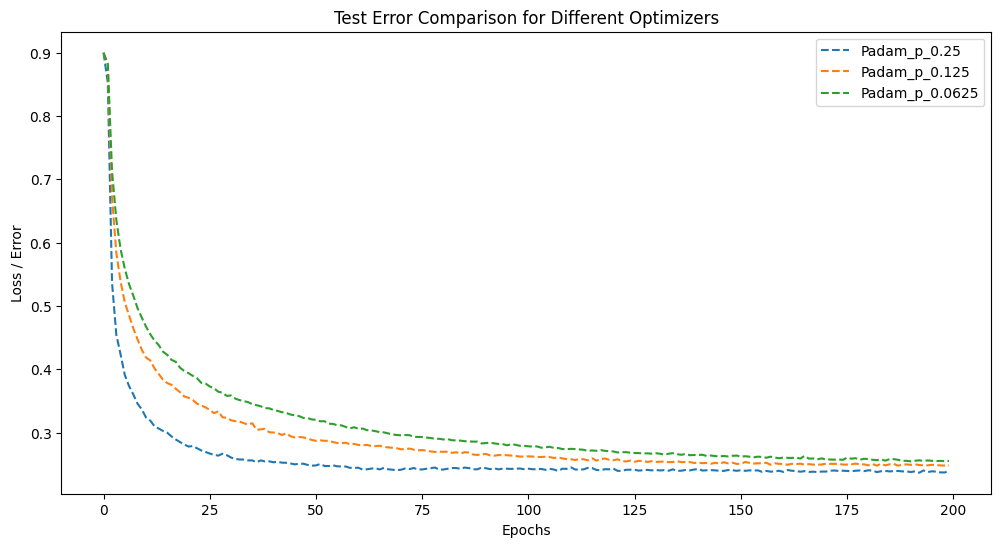

In [15]:
plt.figure(figsize=(12, 6))

for name, history in histories_100epochs.items():
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    plt.plot(test_error, label=f"{name}", linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss / Error')
plt.legend()
plt.title('Test Error Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/Test_Error.png', dpi=300, bbox_inches='tight')
plt.show()

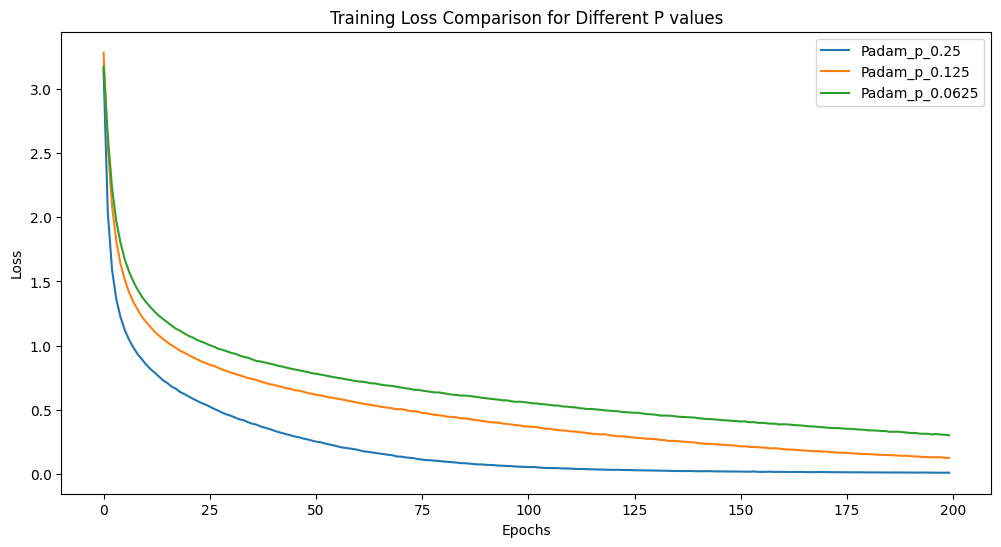

In [16]:
plt.figure(figsize=(12, 6))

for name, history in histories_100epochs.items():
    plt.plot(history.history['loss'], label=f"{name}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison for Different P values')
# Save the figure before displaying it
plt.savefig('./Results/Train_Loss.png', dpi=300, bbox_inches='tight')
plt.show()

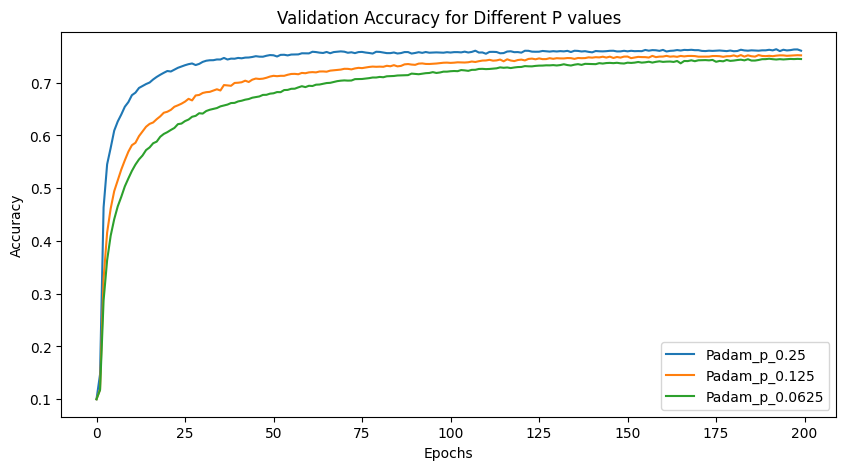

In [17]:
plt.figure(figsize=(10, 5))
for name, history in histories_100epochs.items():
    plt.plot(history.history['val_accuracy'], label=f"{name}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different P values')
plt.savefig('./Results/validation_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

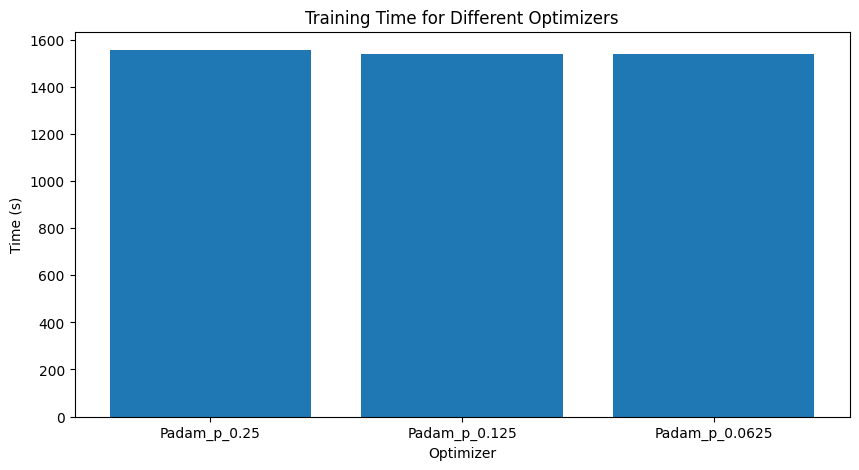

In [18]:
plt.figure(figsize=(10, 5))
plt.bar(training_times_100epochs.keys(), training_times_100epochs.values())
plt.xlabel('Optimizer')
plt.ylabel('Time (s)')
plt.title('Training Time for Different Optimizers')
plt.savefig('./Results/training_time.png', dpi=300, bbox_inches='tight')
plt.show()

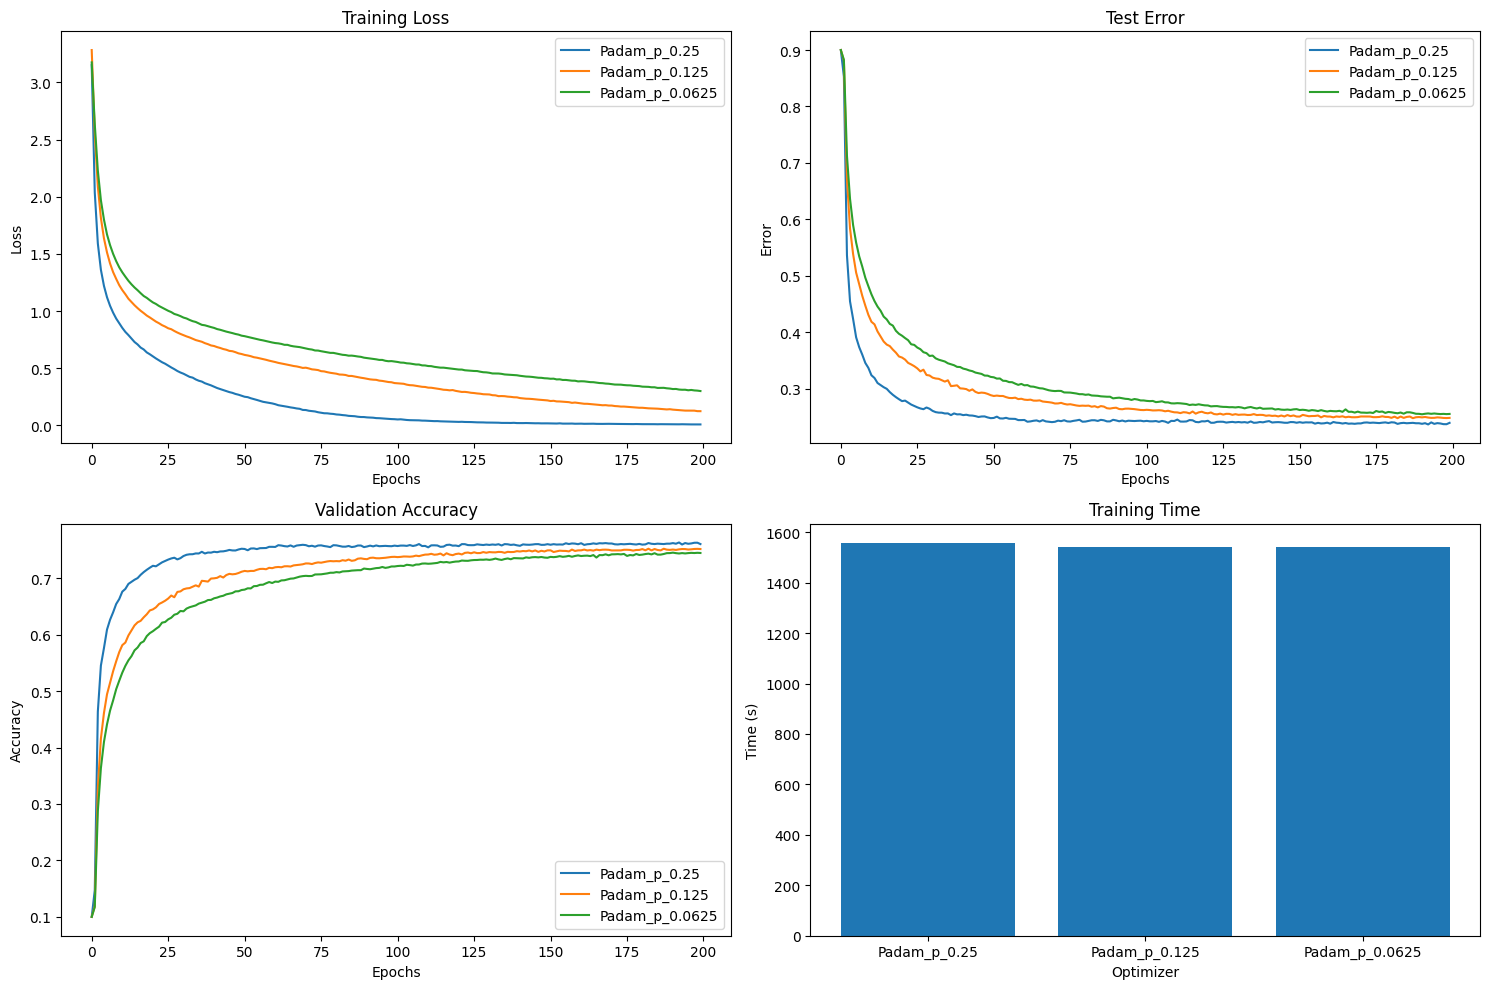

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
for name, history in histories_100epochs.items():
    axes[0, 0].plot(history.history['loss'], label=f"{name}")
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training Loss')

# Test Error
for name, history in histories_100epochs.items():
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    axes[0, 1].plot(test_error, label=f"{name}")
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Error')
axes[0, 1].legend()
axes[0, 1].set_title('Test Error')

# Validation Accuracy
for name, history in histories_100epochs.items():
    axes[1, 0].plot(history.history['val_accuracy'], label=f"{name}")
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Validation Accuracy')

# Training Time
axes[1, 1].bar(training_times_100epochs.keys(), training_times_100epochs.values())
axes[1, 1].set_xlabel('Optimizer')
axes[1, 1].set_ylabel('Time (s)')
axes[1, 1].set_title('Training Time')

plt.tight_layout()
plt.savefig('./Results/matrix.png', dpi=300, bbox_inches='tight')
plt.show()